In [958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras import layers, models

In [891]:
dataset_path = 'C:/Users/tyler/Documents/Usable_AI_Assignments/ObesityDataSet_raw_and_data_sinthetic.csv'

In [893]:
obesity_df = pd.read_csv(dataset_path)

In [895]:
obesity_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Adding yes/no "obesity" column.  This column is yes when 'NObeyesdad' is Obesity_Type_I, II, or III.  The value is no otherwise.  This will be my target vector.

In [775]:
obesity_df['obese'] = np.where(obesity_df['NObeyesdad'].isin(['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']), 'yes', 'no')

In [777]:
obesity_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,obese
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,no
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,no
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,no
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,no
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,no


In [779]:
obesity_df.shape

(2111, 18)

Preliminary Analysis

Gender distribution

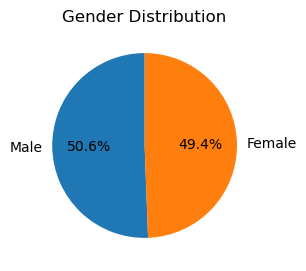

In [783]:
gender_counts = obesity_df['Gender'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()

Age distribution

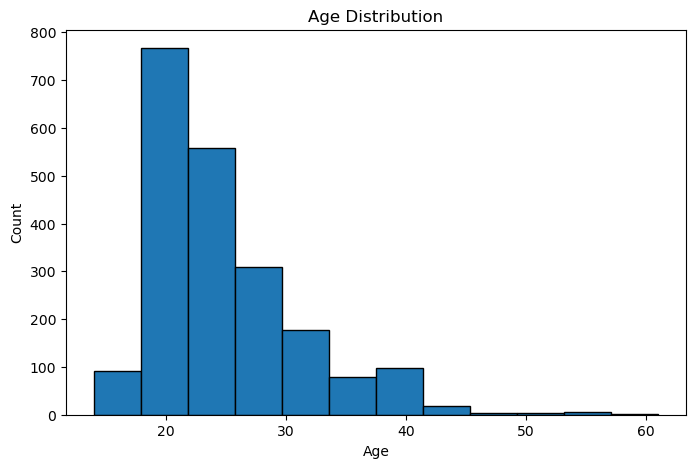

In [786]:
plt.figure(figsize=(8, 5))
plt.hist(obesity_df['Age'], bins=12, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Obesity distribution

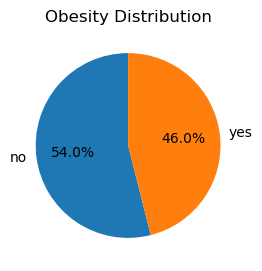

In [789]:
obesity_counts = obesity_df['obese'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(obesity_counts, labels=obesity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Obesity Distribution')
plt.show()

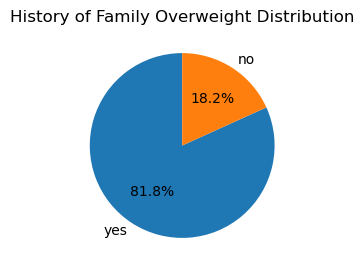

In [791]:
history_counts = obesity_df['family_history_with_overweight'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(history_counts, labels=history_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('History of Family Overweight Distribution')
plt.show()

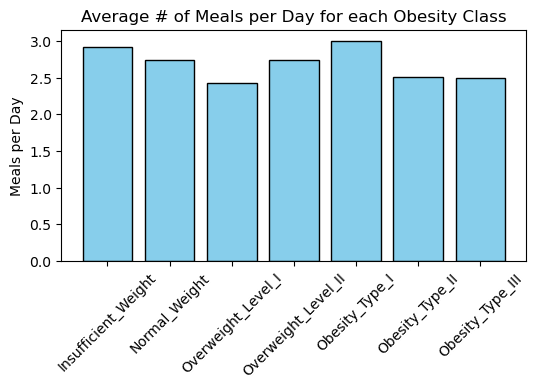

In [793]:
mean_favc_by_class = obesity_df.groupby('NObeyesdad')['NCP'].mean()

plt.figure(figsize=(6, 3))
plt.bar(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 
        mean_favc_by_class.values, color='skyblue', edgecolor='black')
plt.title('Average # of Meals per Day for each Obesity Class')
plt.ylabel('Meals per Day')
plt.xticks(rotation=45) 
plt.show()

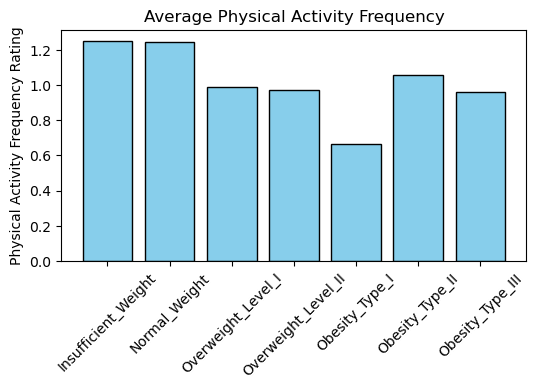

In [795]:
mean_phys_act_by_class = obesity_df.groupby('NObeyesdad')['FAF'].mean()

plt.figure(figsize=(6, 3))
plt.bar(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 
        mean_phys_act_by_class.values, color='skyblue', edgecolor='black')
plt.title('Average Physical Activity Frequency')
plt.ylabel('Physical Activity Frequency Rating')
plt.xticks(rotation=45) 
plt.show()

Data Preprocessing

Removing 'NObeyesdad' column so my only target variable Y is 'obese' column. Also removing age, weight, and height attributes as these are not helpful in predicting which features most correlate to obesity.

In [799]:
obesity_df.drop(['NObeyesdad', 'Age', 'Height', 'Weight'], axis=1, inplace=True)

Converting yes/no features to boolean values

In [802]:
to_boolean = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'obese']

for col in to_boolean:
    obesity_df[col] = obesity_df[col].replace({'yes': True, 'no': False})

C:\Users\tyler\AppData\Local\Temp\ipykernel_18932\3012502453.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity_df[col] = obesity_df[col].replace({'yes': True, 'no': False})


One-hot encoding categorical data

In [805]:
one_hot_cols = ['Gender', 'CAEC', 'CALC', 'MTRANS']

In [807]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_data = encoder.fit_transform(obesity_df[one_hot_cols])

In [809]:
encoded_data_df = pd.DataFrame(one_hot_data, columns=encoder.get_feature_names_out(one_hot_cols))
obesity_df = obesity_df.drop(one_hot_cols, axis=1)
obesity_df = pd.concat([obesity_df, encoded_data_df], axis=1)

Standardizing numerical data

In [812]:
standardize_data = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [814]:
scaler = StandardScaler()

In [816]:
obesity_df[standardize_data] = scaler.fit_transform(obesity_df[standardize_data])

In [818]:
obesity_df.head()

,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,obese,...,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,True,False,-0.784810,0.404102,False,-0.013141,False,-1.188028,0.562005,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,True,False,1.088307,0.404102,True,1.618701,True,2.339676,-1.080619,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,True,False,-0.784810,0.404102,False,-0.013141,False,1.163774,0.562005,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,False,False,1.088307,0.404102,False,-0.013141,False,1.163774,-1.080619,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,False,False,-0.784810,-2.166941,False,-0.013141,False,-1.188028,-1.080619,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Data is ready for model training

Training Logistic Regression model

In [822]:
X = obesity_df.drop(columns='obese')
y = obesity_df['obese']

In [824]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [826]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [1036]:
y_pred = lr.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy Score: 0.7565011820330969
Classification Report:
               precision    recall  f1-score   support

       False     0.8634    0.6695    0.7542       236
        True     0.6750    0.8663    0.7588       187

    accuracy                         0.7565       423
   macro avg     0.7692    0.7679    0.7565       423
weighted avg     0.7801    0.7565    0.7562       423



In [1038]:
cm = confusion_matrix(y_test, y_pred)

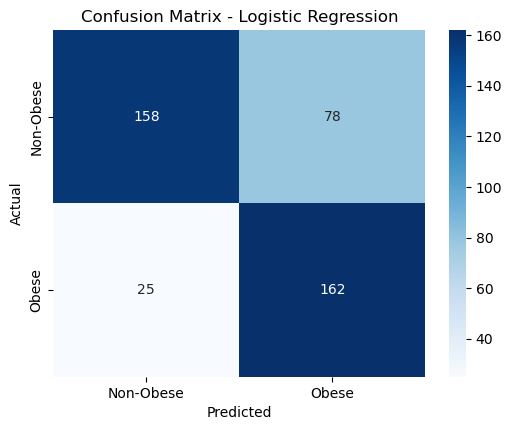

In [1040]:
plt.figure(figsize=(6,4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The logistic regression model was fairly accurate, with 75.7% test accuracy, 78 false positives and 25 false negatives.  I presume that the neural network model will be even more accurate.  This model tended to predict obese for non-obese individuals more than not-obese for obese individuals, possibly due to there being outliers among people with unhealthy habits that are not obese.

In [861]:
top_features = pd.Series(lr.coef_[0], index=X.columns).abs().sort_values(ascending=False)
print(top_features)

family_history_with_overweight    3.269405
FAVC                              2.201076
SCC                               1.790423
CAEC_Sometimes                    1.784110
CAEC_Frequently                   1.460461
MTRANS_Walking                    1.356880
SMOKE                             1.036286
MTRANS_Public_Transportation      0.676472
CAEC_no                           0.496440
FCVC                              0.433618
MTRANS_Motorbike                  0.428403
CALC_Frequently                   0.315152
FAF                               0.290824
CALC_Sometimes                    0.228368
TUE                               0.220263
CAEC_Always                       0.180683
MTRANS_Bike                       0.159901
MTRANS_Automobile                 0.099996
CALC_no                           0.099102
CH2O                              0.088677
NCP                               0.045492
Gender_Male                       0.010338
CALC_Always                       0.004427
Gender_Fema

By extracting the model coefficients, I see that the most important factor that the model found correlated with obesity is family history of obesity.  I found this very interesting, as I expected this to be an important feature but not the top feature.  The next most important were frequency of consuming high calorie foods, and if the person monitors their calorie intake.  Gender and high alcohol consumption (surprisingly) were the least correlated with predicting obesity.

Training Neural Network Model

In [897]:
nn_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [899]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [901]:
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5552 - loss: 0.6868 - val_accuracy: 0.6805 - val_loss: 0.6331
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7082 - loss: 0.6009 - val_accuracy: 0.7160 - val_loss: 0.5684
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7502 - loss: 0.5261 - val_accuracy: 0.7130 - val_loss: 0.5287
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7768 - loss: 0.4574 - val_accuracy: 0.7515 - val_loss: 0.4884
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8009 - loss: 0.4157 - val_accuracy: 0.7811 - val_loss: 0.4553
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8305 - loss: 0.3805 - val_accuracy: 0.7840 - val_loss: 0.4434
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8337 - loss: 0.3631 - val_accuracy: 0.8047 - val_loss: 0.4243
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8496 - loss: 0.3401 - val_accuracy: 0.8195 - val_l

In [1042]:
loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {round(accuracy, 4)}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8982 - loss: 0.4335
Test Accuracy: 0.8889


In [1044]:
y_pred = nn_model.predict(X_test, verbose=False) > 0.5

In [1046]:
cm = confusion_matrix(y_test, y_pred)

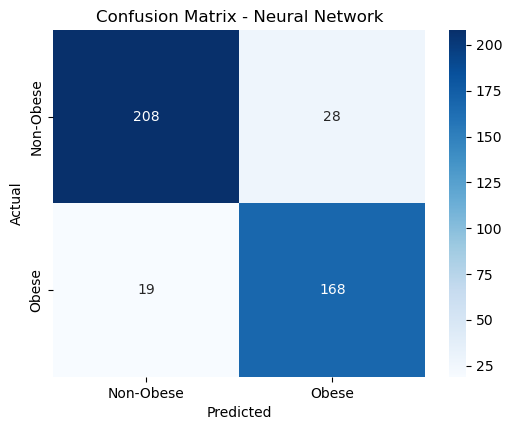

In [1048]:
plt.figure(figsize=(6,4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

My neural network received better test accuracy than my logistic regression model as expected, with 88.9% compared to 75.7% using LR.  Using this model I had 28 false positives and 19 false negatives.  I had roughly the same amount of false negatives, with much less false positives.  The neural network appeared to have been better at extracting meaningful and loss obvious information in people that seemed to have some obese characteristics (that LR would have classified as obese), but were correctly classified as not obese.

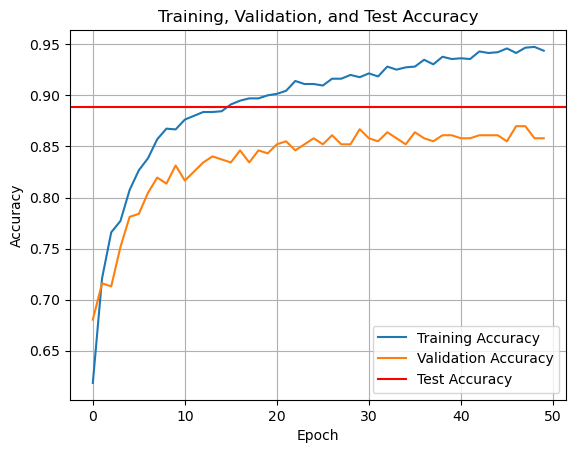

In [946]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Finding meaningful features in the neural network model.  There is no easy way to simply extract coefficients like with logistic regression, so I used the drop-column importance method.  I went through each feature column and shuffled the data, and tested how much losing this feature hurt the performance of the model.  Features that cause more average drop in test accuracy mean this feature was important to the accuracy of the model.

In [1012]:
importances = []

for col in X_test.columns:
    scores = []
    for i in range(5):
        X_test_copy = X_test.copy()
        X_test_copy[col] = np.random.permutation(X_test_copy[col])
        y_pred = nn_model.predict(X_test_copy, verbose=False) > 0.5
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    mean_drop = accuracy - np.mean(scores)
    importances.append((col, mean_drop))

importance_df = pd.DataFrame(importances, columns=["feature", "importance_drop"]).sort_values(by="importance_drop", ascending=False)

In [1014]:
pd.set_option('display.float_format', '{:.6f}'.format)

Sorted by features causing the biggest difference in model accuracy.  Shuffling data on frequency of vegetable consumption caused a 10.8% drop in test accuracy.

While this method of testing feature importance is not perfect, I found some interesting results.  First, I found that the family history of overweight column being changed caused the 3rd highest change in the model's average performance, and this was the most important feature in the logistic regression model.  This tells me that this is clearly a very important factor.  Frequency of vegetable consumption interestingly caused the biggest change in the neural network's results, while this was middle of the pack in importanace for the logistic regression model.

In [1016]:
importance_df

,feature,importance_drop
2,FCVC,0.107801
3,NCP,0.106383
0,family_history_with_overweight,0.073759
8,TUE,0.066667
5,CH2O,0.049645
7,FAF,0.044917
1,FAVC,0.042080
9,Gender_Female,0.039716
19,MTRANS_Automobile,0.027423
16,CALC_Frequently,0.026950
